In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib agg
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
       
from HPIB.HP4155 import HP4155
from HPIB.HPT import Plot, PlotVgs, PlotVp, CalcIsSat, SecDer, Plot2P, PlotDiode4P
from HPIB.DevParams import UMC
from HPIB.INOSerial import Arduino

from BFmodule import DR

from YFunc import YFuncExtraction

from IPython.display import clear_output, display
from os import makedirs, rename
from os.path import isfile
from time import sleep
from datetime import datetime, timedelta

Elsa=DR()

HP=HP4155("GPIB0::17", debug=False)

In [55]:
def WriteLog(msg, path, mode='a', end='\n', output=True):
    with open(path, mode) as logfile:
        logfile.write(msg+end)
    if output:
        print(f"{msg}{end}", end='')

def TestDevice(device, chn, path, params, HiPot=False):
    global HP, INO, Elsa, prog_bar
    INO.opench(chn+1)

    if not device:
        INO.opench(0)
        sleep(2)
        return 0

    if device[:2].upper() not in ['CA', 'CB', 'CG', 'TP', 'TN', 'DP', 'DN']:
        return "Invalid device"

    pathp=path+device
    makedirs(pathp, exist_ok=True)
    WriteLog(f"## Ch {chn+1} {device}", path + 'log.txt')
    
    ####################### Measure Diode
    #
    #
    if 'D' in device.upper():
        
        HP.StopCond="COMP"
        HP.IntTime="MED"
        HP.Diode4P(params['Vfmin'], params['Vfmax'], params['Vfstep'], Comp=params['IComp'] if not HiPot else 2*params['IComp'])
            
        now=datetime.now().strftime('%y%m%d %H%M%S')
        V100, V10=PlotDiode4P(HP.SingleSave(f"{pathp}/{now}.csv", timeout=30, real=True))
        try:
            temp=format(Elsa.GetT('t4k'), '07.3f')
            rename(f"{pathp}/{now}.csv", f"{pathp}/Diode - {temp} - {now}.csv")
            rename(f"{pathp}/{now}.png", f"{pathp}/Diode - {temp} - {now}.png")
            rename(f"{pathp}/{now} log.png", f"{pathp}/Diode - {temp} - {now} log.png")
            
            with open(f"{pathp}/V10010uA.log", 'a') as DiodeParam:
                DiodeParam.write(f"{temp},{format(V100, '.3f')},{format(V10, '.3f')}\n")
        except Exception as err:
            print (">>> Error:", err)
        
        now=datetime.now()
            
        while (datetime.now()-now).seconds < params['min_wait']:
            prog_bar.update(f"Waiting: {params['min_wait']-(datetime.now()-now).seconds} s")
            sleep(0.5)
        prog_bar.update("Measuring")
            
        HP.StopCond="OFF"
        HP.IntTime="LONG"
        
        INO.opench(0)
        WriteLog('', path + 'log.txt')
        return 0
    #
    #
    #######################

    ####################### Measure Transistor
    #
    #

    if 'T' in device.upper():
        log_param=f"{pathp}/{datetime.now().strftime('%y%m')} {device} Parameters.log"
        ptype='P' in device.upper()
        
        HP.SetVgs(params['Vgsmin'], params['Vgsmax'], params['Vstep']/2 if HiPot else params['Vstep'], params['Vd'], ptype=ptype)
  
        now=datetime.now().strftime('%y%m%d %H%M')
        LIN = PlotVgs(HP.SingleSave(f"{pathp}/IdVgs - {now}.csv", timeout=30))
        
        try:
            temp=format(Elsa.GetT('t4k'), '07.3f')
            newname=f"{pathp}/IdVgs - {temp} - {now}"
            rename(f"{pathp}/IdVgs - {now}.csv", f"{newname}.csv")
            rename(f"{pathp}/IdVgs - {now}.png", f"{newname}.png")
        except Exception as err:
            print (">>> Error:", err)
        now=datetime.now()
        if not isfile(log_param):
            with open(log_param, 'w') as myfile:
                myfile.write('temp,LIN,Vth,SS1,SS2,migm,miyf,theta1,theta2,Rext1,Rext2,beta,errmax%\n')
                
        try:
            LIN, Vth, SS1, SS2, migm, miyf, theta1, theta2, Rext1, Rext2, beta, errmax = YFuncExtraction(f"{newname}.csv", temp, UMC[int(device[2:])], 4.2, 3.9, params['Vd'])
            WriteLog(f"LIN={format(LIN, '.3f')}, Vth={format(Vth, '.3f')} V, SS={format(SS2, '.2f')} mV/dec, migm={format(migm, '.1f')}, miyf={format(miyf, '.1f')}, theta1={format(theta1, '.3e')}, theta2={format(theta2, '.3e')}", path + 'log.txt')
            WriteLog(f"{temp},{format(LIN, '1.3f')},{format(Vth, '1.3f')},{format(SS1,'6.2f')},{format(SS2,'6.2f')},{format(migm, '.4e')},{format(miyf, '.4e')},{format(theta1, '+.3e')},{format(theta2, '+.3e')},{format(Rext1, '.3e')},{format(Rext2, '.3e')},{format(beta, '.3e')},{format(errmax, '.3e')}", log_param)
        except Exception as err:
            print (">>> Error:", err)
            WriteLog(f"Vth={LIN} V", path + 'log.txt')
        
        while (datetime.now()-now).seconds < params['min_wait']:
            prog_bar.update(f"Waiting: {params['min_wait']-(datetime.now()-now).seconds} s")
            sleep(0.5)
        prog_bar.update("Measuring")
            
        if HiPot:
            now=datetime.now().strftime('%y%m%d %H%M')
            HP.SetVgs(params['Vgsmin'], params['Vgsmax'], params['Vstep'], params['Vgsmax'], ptype=ptype, sat=True)
            HP.SingleSave(f"{pathp}/IdVgsSat - {now}.csv", timeout=30)
            try:
                temp=format(Elsa.GetT('t4k'), '07.3f')
                rename(f"{pathp}/IdVgsSat - {now}.csv", f"{pathp}/IdVgsSat - {temp} - {now}.csv")
            except Exception as err:
                print(">>> Error:", err)
            n, Ispec = CalcIsSat(f"{pathp}/IdVgsSat - {temp} - {now}.csv", float(temp))
            WriteLog(f"n={format(n, '.3f')}, Ispec={format(Ispec, '.3e')} A", path + 'log.txt')

            now=datetime.now()
            while (datetime.now()-now).seconds < 4*params['min_wait']:
                prog_bar.update(f"Waiting: {4*params['min_wait']-(datetime.now()-now).seconds} s")
                sleep(0.5)
            prog_bar.update("Measuring")
            
            if Ispec != 0:
                now=datetime.now().strftime('%y%m%d %H%M')
                HP.SetVp(Ispec, params['Vdsmin'], params['Vdsmax'], 0.05, ptype=ptype)
                HP.SingleSave(f"{pathp}/VpVg - {now}.csv", timeout=30)
                try:
                    temp=format(Elsa.GetT('t4k'), '07.3f')
                    rename(f"{pathp}/VpVg - {now}.csv", f"{pathp}/VpVg - {temp} - {now}.csv")
                except Exception as err:
                    print (">>> Error:", err)
                VTO=PlotVp(f"{pathp}/VpVg - {temp} - {now}.csv")
                WriteLog(f"VTO={VTO} V", path + 'log.txt')

                now=datetime.now()
                while (datetime.now()-now).seconds < 4*params['min_wait']:
                    prog_bar.update(f"Waiting: {4*params['min_wait']-(datetime.now()-now).seconds} s")
                    sleep(0.5)
                prog_bar.update("Measuring")

            now=datetime.now().strftime('%y%m%d %H%M')
            HP.SetVds(params['Vdsmin'], params['Vdsmax'], params['Vstep'], params['Vgmin'], params['Vgmax'], params['Vgstep'], ptype=ptype)
            HP.SingleSave(f"{pathp}/IdVdsUp - {now}.csv", timeout=30)
            try:
                temp=format(Elsa.GetT('t4k'), '07.3f')
                rename(f"{pathp}/IdVdsUp - {now}.csv", f"{pathp}/IdVdsUp - {temp} - {now}.csv")
            except Exception as err:
                print (">>> Error:", err)
            Plot(f"{pathp}/IdVdsUp - {temp} - {now}.csv", 'Vd', 'Id')
            
            now=datetime.now()
            while (datetime.now()-now).seconds < 4*params['min_wait']:
                prog_bar.update(f"Waiting: {4*params['min_wait']-(datetime.now()-now).seconds} s")
                sleep(0.5)
            prog_bar.update("Measuring")

            now=datetime.now().strftime('%y%m%d %H%M')
            HP.SetVds(params['Vdsmax'], params['Vdsmin'], -params['Vstep'], params['Vgmin'], params['Vgmax'], params['Vgstep'], ptype=ptype)
            HP.SingleSave(f"{pathp}/IdVdsDown - {now}.csv", timeout=30)
            try:
                temp=format(Elsa.GetT('t4k'), '07.3f')
                rename(f"{pathp}/IdVdsDown - {now}.csv", f"{pathp}/IdVdsDown - {temp} - {now}.csv")
            except Exception as err:
                print (">>> Error:", err)
            Plot(f"{pathp}/IdVdsDown - {temp} - {now}.csv", 'Vd', 'Id')
            
            now=datetime.now()
            while (datetime.now()-now).seconds < 4*params['min_wait']:
                prog_bar.update(f"Waiting: {4*params['min_wait']-(datetime.now()-now).seconds} s")
                sleep(0.5)
            prog_bar.update("Measuring")
            
        INO.opench(0)
        WriteLog('', path + 'log.txt')
        return 0
    #
    #
    #######################
        
    ####################### Measure CrossBridge
    #
    #
    if 'CG' in device.upper():
           
        now=datetime.now().strftime('%y%m%d %H%M')
        V10u=HP.MeasV10u(f"{pathp}/2P - {now}.csv", timeout=0.5)
        try:
            temp=format(Elsa.GetT('t4k'), '07.3f')
            rename(f"{pathp}/2P - {now}.csv", f"{pathp}/2P - {temp} - {now}.csv")
            rename(f"{pathp}/2P - {now}.png", f"{pathp}/2P - {temp} - {now}.png")
        except Exception as err:
            print (">>> Error:", err)
        WriteLog(f"V_10u={format(V10u, '.2f')}", path + 'log.txt')
        with open(f"{pathp}/VxT 10uA.log", 'a') as VxT:
            VxT.write(f"{temp},{format(V10u, '.4e')}\n")

    if 'CA' in device.upper():

        HP.Set2P(params['Ifmin']/params['Iffactor'], params['Ifmax']/params['Iffactor'], params['Ifpoints'], SMUN='SMU1', SMUP='SMU2', Comp=params['VComp'])
            
        now=datetime.now().strftime('%y%m%d %H%M')
        Rshort=Plot2P(HP.SingleSave(f"{pathp}/2P - {now}.csv", timeout=30))
        try:
            temp=format(Elsa.GetT('t4k'), '07.3f')
            rename(f"{pathp}/2P - {now}.csv", f"{pathp}/2P - {temp} - {now}.csv")
            rename(f"{pathp}/2P - {now}.png", f"{pathp}/2P - {temp} - {now}.png")
        except Exception as err:
            print (">>> Error:", err)
        WriteLog(f"Rshort={format(Rshort, '.2f')}", path + 'log.txt')
        with open(f"{pathp}/RxT 2P.log", 'a') as RxT2p:
            RxT2p.write(f"{temp},{format(Rshort, '.2f')}\n")

    if 'CB' in device.upper():
    
        HP.Set4P(params['Ifmin'], params['Ifmax'], params['Ifpoints'])
        
        now=datetime.now().strftime('%y%m%d %H%M')
        RCB=Plot2P(HP.SingleSave(f"{pathp}/4P - {now}.csv", timeout=30))
        try:
            temp=format(Elsa.GetT('t4k'), '07.3f')
            rename(f"{pathp}/4P - {now}.csv", f"{pathp}/4P - {temp} - {now}.csv")
            rename(f"{pathp}/4P - {now}.png", f"{pathp}/4P - {temp} - {now}.png")
        except Exception as err:
            print (">>> Error:", err)
        WriteLog(f"RCB={format(RCB, '.2e')}", path + 'log.txt')
        with open(f"{pathp}/RxT 4P.log", 'a') as RxT4p:
            RxT4p.write(f"{temp},{format(RCB, '.2e')}\n")

    now=datetime.now()
    while (datetime.now()-now).seconds < params['min_wait']:
        prog_bar.update(f"Waiting: {params['min_wait']-(datetime.now()-now).seconds} s")
        sleep(0.5)
    prog_bar.update("Measuring")
            
    INO.opench(0)
    WriteLog('', path + 'log.txt')
    return 0
    #
    #
    #######################

In [53]:
params = {
'Vd' : 0.05,
'Vgsmin' : 0,
'Vgsmax' : 1.5,
'Vstep' : 0.02,

'Vgmin' : 0.6,
'Vgmax' : 1.4,
'Vdsmin' : 0,
'Vdsmax' : 1.5,
'Vgstep' : 0.2,

'Vfmin' : 0,
'Vfmax' : 2,
'Vfstep' : 0.01,
'IComp' : 2e-3,

'Ifmin' : -1e-3,
'Ifmax' : 1e-3,
'Ifpoints' : 50,
'Iffactor' : 50,
'VComp' : 1.5,

'min_wait' : 15
}

params2 = {
'Vd' : 0.05,
'Vgsmin' : 0,
'Vgsmax' : 1.7,
'Vstep' : 0.02,

'Vgmin' : 0.4,
'Vgmax' : 1.4,
'Vdsmin' : 0,
'Vdsmax' : 1.5,
'Vgstep' : 0.25,

'Vfmin' : 0,
'Vfmax' : 2,
'Vfstep' : 0.01,
'IComp' : 1e-3,

'Ifmin' : -1e-3,
'Ifmax' : 1e-3,
'Ifpoints' : 50,
'Iffactor' : 50,
'VComp' : 1.5,

'min_wait' : 15
}

DeviceList = ['TN5', 'DN8']
# DeviceList = ['', 'DN1']

prepath = "C:/Users/Zucchi/Documents/Medidas/250901 TN5DN8/"

In [38]:
INO.opench(3)

'Open INO: ch 3'

In [41]:
HP.Diode4P(0, -1.2, 0.05)

Diode=(0, -1.2, 0.05)


0

In [42]:
prog_bar=display('',display_id=True)
TestDevice("DN8", 1, prepath+"Test/", params)

'Measuring'

## Ch 2 DN8
Diode=(0, 1.5, 0.01)
Done Diode4P. Duration: 18 s                                     



0

In [44]:
## Pre measurement

try:
    current_temp=Elsa.GetT('t4k')
except:
    pass

if current_temp > 150:
    path = prepath+"PreCool/"
else:
    path = prepath+"Cold/"
makedirs(path, exist_ok=True)

MsrNo=3 ## Tak|e {MsrNo} measurements
MsrWait=1 ## wait {MsrWait} minutes

HP.IntTime='LONG'
HP.LongNPLC=4

prog_bar=display('',display_id=True)

for i in range(MsrNo):
    start=datetime.now()
    try:
        current_temp=Elsa.GetT('t4k')
    except:
        current_temp='Fail'
    Measurement_Msg=f"#  Measurement {i+1} - {current_temp} - {start.strftime('%y%m%d %H%M')}\n"
    WriteLog(Measurement_Msg, path+'log.txt')
    
    for chn, device in enumerate(DeviceList):
        clear_output()
        prog_bar=display('Measuring',display_id=True)
        print(Measurement_Msg)
        if device:
            TestDevice(device, chn, path, params)
    
    try:
        current_temp=Elsa.GetT('t4k')
    except:
        current_temp='Fail'
    WriteLog(f"Measurement {i+1} end - {current_temp}. Duration: {int((datetime.now()-start).seconds/60)}:{(datetime.now()-start).seconds%60:02d}\n\n#######################\n", path + 'log.txt')

    clear_output()
    plt.close('all')
    prog_bar=display('',display_id=True)
    if i < MsrNo-1:
        start=datetime.now()
        while (datetime.now()-start).seconds < MsrWait*60:
            prog_bar.update(f"Waiting: {int(MsrWait*60)-(datetime.now()-start).seconds} s")
            sleep(1)    
prog_bar.update("Pre measurement done")

'Pre measurement done'

In [45]:
###### Vac measurement

# P6=500

# prog_bar=display('',display_id=True)

# while P6 < 0.9 and P6 >1e-3:
#     try:
#         P6=Elsa.GetPCh(6)
#     except:
#         pass
#     prog_bar.update(f"{datetime.now().strftime('%H:%M:%S')} - P6 = {format(P6, '.1f')} mBarr")
#     sleep(1)

try:
    current_temp=Elsa.GetT('t4k')
except:
    pass

if current_temp > 150:
    path = prepath+"Vac/"
else:
    path = prepath+"Cold/"
makedirs(path, exist_ok=True)

MsrNo=3 ## Take {MsrNo} measurements
MsrWait=1 ## wait {MsrWait} minutes

HP.IntTime='LONG'
HP.LongNPLC=4

for i in range(MsrNo):
    start=datetime.now()
    try:
        current_temp=Elsa.GetT('t4k')
    except:
        current_temp='Fail'
    Measurement_Msg=f"#  Measurement {i+1} - {current_temp} - {start.strftime('%y%m%d %H%M')}\n"
    WriteLog(Measurement_Msg, path+'log.txt')
    
    for chn, device in enumerate(DeviceList):
        clear_output()
        prog_bar=display('Measuring',display_id=True)
        print(Measurement_Msg)
        if device:
            TestDevice(device, chn, path, params, True)
    
    try:
        current_temp=Elsa.GetT('t4k')
    except:
        current_temp='Fail'
    WriteLog(f"Measurement {i+1} end - {current_temp}. Duration: {int((datetime.now()-start).seconds/60)}:{(datetime.now()-start).seconds%60:02d}\n\n#######################\n", path + 'log.txt')

    clear_output()
    plt.close('all')
    prog_bar=display('',display_id=True)
    if i < (MsrNo-1):
        start=datetime.now()
        while (datetime.now()-start).seconds < MsrWait*60:
            prog_bar.update(f"Waiting: {int(MsrWait*60)-(datetime.now()-start).seconds} s")
            sleep(1)
    
prog_bar.update("Vac measurement done")

'Vac measurement done'

In [93]:
###### Warmup measurement

try:
    current_temp=Elsa.GetT('t4k')
except:
    pass

if current_temp > 150:
    path = prepath+"Cooldown/"
else:
    path = prepath+"Warmup/"
makedirs(path, exist_ok=True)

freq_temp=10
MsrNo=3 ## Take {MsrNo} measurements
MsrWait=0.5 ## wait {MsrWait} minutes
# failsafe_time=[60, 120, 120, 60] ## Maximum wait time between measurements (API crash failsafe)
# failsafe_temp=[0, 120, 180, 300] ## is fitted from these temps and times
# failsafe=np.polyfit(failsafe_time, failsafe_temp, 2)
failsafe=[-2.4e-03, 4.3e-01, 1.3e+02]

HP.IntTime='LONG'
HP.LongNPLC=4

clear_output()

prog_bar=display('',display_id=True)

try:
    current_temp=Elsa.GetT('t4k')
except:
    pass

if current_temp > 150: finish_temp=15
else: finish_temp=295

last_temp=150

while (last_temp != finish_temp):
    #loop until temp changes and is a multiple of freq_temp
    MaxWait=np.polyval(failsafe, last_temp) ## API crash failsafe calculation
    start=datetime.now()
    while (np.around(current_temp)==last_temp or np.around(current_temp)%freq_temp != 5):
        if (datetime.now()-start).seconds/60 > MaxWait: ## Failsafe trigger
            break
        for i in range(15):
            prog_bar.update(f"{datetime.now().strftime('%H:%M:%S')} - T = {format(current_temp, '.1f')} K")
            sleep(1)
    
        current_temp=Elsa.GetT('t4k')

    last_temp=np.around(current_temp)
    
    for Msr in range(MsrNo):
        plt.close('all')
        clear_output()
        prog_bar=display('Measuring',display_id=True)

        start=datetime.now()
        WriteLog(f"# {current_temp} K - Measurement {Msr+1} - {datetime.now().strftime('%y%m%d %H%M')}\n", path+'log.txt')
        for chn, device in enumerate(DeviceList):
            if device:
                TestDevice(device, chn, path, params)
    
        WriteLog(f"{current_temp} K - Measurement {Msr+1} end . Duration: {int((datetime.now()-start).seconds/60)}:{(datetime.now()-start).seconds%60:02d}\n\n#######################\n", path + 'log.txt')

    try:
        current_temp=Elsa.GetT('t4k')
    except:
        pass
    if i < MsrNo:
        start=datetime.now()
        while (datetime.now()-start).seconds < MsrWait*60:
            prog_bar.update(f"Waiting: {int(MsrWait*60)-(datetime.now()-start).seconds} s")
            sleep(1)
prog_bar.update("Ramp measurement done")

'Measuring'

# 24.5842 K - Measurement 1 - 250905 1910



SerialException: WriteFile failed (PermissionError(13, 'Access is denied.', None, 5))

In [63]:
HP.Set4PSMU(-1e-3, 1e-3, 100, Im='SMU1', Ip='SMU2', Vm='SMU3', Vp='SMU4', Comp=2)

Set 4P
I=(-0.001, 0.001), 100 Points


0

In [91]:
HP.get_data()

Trace,I2,If,Vf
None,None,None,None
0,-1.171000E-011,+1.400000E-012,-4.000000E-006
1,+9.488800E-010,+9.282700E-010,+5.001200E-002
2,+4.629920E-009,+4.599090E-009,+1.000020E-001
3,+1.816730E-008,+1.796690E-008,+1.499900E-001
4,+6.435230E-008,+6.433290E-008,+1.999600E-001
5,+2.247370E-007,+2.222320E-007,+2.499520E-001
6,+7.736590E-007,+7.728520E-007,+2.999640E-001
7,+2.877900E-006,+2.849640E-006,+3.499620E-001
8,+1.117770E-005,+1.116841E-005,+3.999760E-001


In [92]:
HP.get_realdata()

Trace,I2,If,Vf
None,None,None,None
0,-1.171000e-11,1.400000e-12,-0.000004
1,9.488800e-10,9.282700e-10,0.050012
2,4.629920e-09,4.599090e-09,0.100002
3,1.816730e-08,1.796690e-08,0.149990
4,6.435230e-08,6.433290e-08,0.199960
5,2.247370e-07,2.222320e-07,0.249952
6,7.736590e-07,7.728520e-07,0.299964
7,2.877900e-06,2.849640e-06,0.349962
8,1.117770e-05,1.116841e-05,0.399976


In [85]:
V=[float(x) for x in df["Vf"]["None"].to_numpy()]
I=[float(x) for x in df["If"]["None"].to_numpy()]

array([ 1.00209870e+01, -1.09895156e-05])

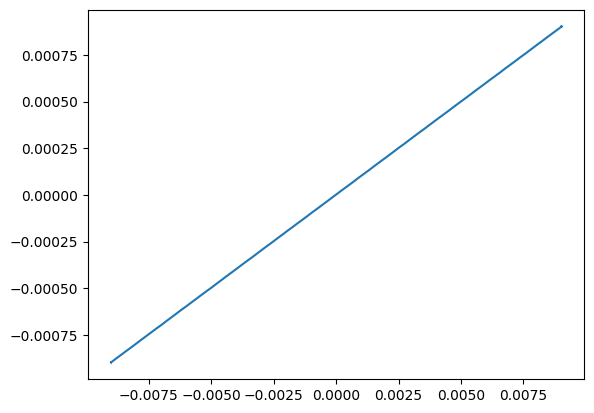

In [90]:
%matplotlib inline

plt.plot(V, I)

np.polyfit(I, V, 1)

In [47]:
###### Warmup measurement

try:
    current_temp=Elsa.GetT('t4k')
except:
    pass

freq_temp=2
MsrNo=3 ## Take {MsrNo} measurements
MsrWait=0.5 ## wait {MsrWait} minutes
# failsafe_time=[60, 120, 120, 60] ## Maximum wait time between measurements (API crash failsafe)
# failsafe_temp=[0, 120, 180, 300] ## is fitted from these temps and times
# failsafe=np.polyfit(failsafe_time, failsafe_temp, 2)
failsafe=[-2.4e-03, 4.3e-01, 1.3e+02]

HP.IntTime='LONG'
HP.LongNPLC=4

clear_output()

prog_bar=display('',display_id=True)

try:
    current_temp=Elsa.GetT('t4k')
except:
    pass

finish_temp=5


while (last_temp != finish_temp):
    #loop until temp changes and is a multiple of freq_temp
    MaxWait=np.polyval(failsafe, last_temp) ## API crash failsafe calculation
    start=datetime.now()
    while (np.around(current_temp)==last_temp or (np.around(current_temp)%freq_temp>0.25 and np.around(current_temp)%freq_temp<1.75)):
        if (datetime.now()-start).seconds/60 > MaxWait: ## Failsafe trigger
            break
        for i in range(15):
            prog_bar.update(f"{datetime.now().strftime('%H:%M:%S')} - T = {format(current_temp, '.1f')} K")
            sleep(1)
    
        current_temp=Elsa.GetT('t4k')

    last_temp=np.around(current_temp)
    
    for Msr in range(MsrNo):
        plt.close('all')
        clear_output()
        prog_bar=display('Measuring',display_id=True)

        start=datetime.now()
        WriteLog(f"# {current_temp} K - Measurement {Msr+1} - {datetime.now().strftime('%y%m%d %H%M')}\n", path+'log.txt')
        for chn, device in enumerate(DeviceList):
            if device:
                TestDevice(device, chn, path, params)
    
        WriteLog(f"{current_temp} K - Measurement {Msr+1} end . Duration: {int((datetime.now()-start).seconds/60)}:{(datetime.now()-start).seconds%60:02d}\n\n#######################\n", path + 'log.txt')

    try:
        current_temp=Elsa.GetT('t4k')
    except:
        pass
    if i < MsrNo:
        start=datetime.now()
        while (datetime.now()-start).seconds < MsrWait*60:
            prog_bar.update(f"Waiting: {int(MsrWait*60)-(datetime.now()-start).seconds} s")
            sleep(1)
prog_bar.update("Ramp measurement done")

'12:00:08 - T = 4.4 K'

# 4.4988 K - Measurement 3 - 250903 1147

## Ch 1 TN5
Set IdxVgs
Vg=(0, 1.5, 0.02), Vd=0.05, Ilim=0.001
Done IdxVgs. Duration: 16 s                                     
(400, 3000.0)
LIN=0.773, Vth=0.757 V, SS=12.08 mV/dec, migm=40313.2, miyf=47638.4, theta1=3.538e-01, theta2=2.333e-01
004.465,0.773,0.757,-57.41, 12.08,4.0313e+04,4.7638e+04,+3.538e-01,+2.333e-01,9.975e+01,9.857e+01,5.222e-03,6.018e-01

## Ch 2 DN8
Diode=(0, 1.5, 0.01)
Done Diode4P. Duration: 17 s                                     

4.4988 K - Measurement 3 end . Duration: 1:17

#######################



KeyboardInterrupt: 

In [49]:
###### 4 K wait and 3 Hour transitory measurement

current_temp=Elsa.GetT('t4k')

prog_bar=display('',display_id=True)

path = prepath+"ColdWait/"
makedirs(path, exist_ok=True)

while (np.around(current_temp, 1))> 4.5:
    
        for i in range(15):
            prog_bar.update(f"{datetime.now().strftime('%H:%M:%S')} - T = {format(current_temp, '.1f')} K")
            sleep(1)

        current_temp=Elsa.GetT('t4k')

meas_freq=10
MsrNo=18

for Msr in range(MsrNo):
    plt.close('all')
    clear_output()
    prog_bar=display('Measuring',display_id=True)
    start=datetime.now()

    start=datetime.now()
    WriteLog(f"# {current_temp} K - Measurement {Msr+1} - {datetime.now().strftime('%y%m%d %H%M')}\n", path+'log.txt')
    for chn, device in enumerate(DeviceList):
        if device:
            TestDevice(device, chn, path, params)

    WriteLog(f"{current_temp} K - Measurement {Msr+1} end . Duration: {int((datetime.now()-start).seconds/60)}:{(datetime.now()-start).seconds%60:02d}\n\n#######################\n", path + 'log.txt')
    while (datetime.now()-start).seconds < meas_freq*60:
        prog_bar.update(f"Waiting: {meas_freq*60-(datetime.now()-start).seconds} s")
        sleep(1)

'Measuring'

# 4.35173 K - Measurement 3 - 250903 1545

## Ch 1 TN5
Set IdxVgs
Vg=(0, 1.5, 0.02), Vd=0.05, Ilim=0.001
Done IdxVgs. Duration: 16 s                                     
(400, 3000.0)
LIN=0.786, Vth=0.716 V, SS=25.88 mV/dec, migm=40945.1, miyf=35621.0, theta1=-2.654e-01, theta2=5.572e-01
003.789,0.786,0.716,-114.65, 25.88,4.0945e+04,3.5621e+04,-2.654e-01,+5.572e-01,1.197e+02,1.166e+02,3.905e-03,7.671e-01

## Ch 2 DN8
Diode=(0, 1.5, 0.01)
Done Diode4P. Duration: 17 s                                     

4.35173 K - Measurement 3 end . Duration: 1:17

#######################



KeyboardInterrupt: 

In [61]:
HP.SetSMU("SMU3", "V3", "I3", "I", "CONS", Value=0, Comp=2)

0

In [56]:
###### Post measurement

if Elsa.GetT('t4k') > 150:
    path = prepath+"PostCool/"
else:
    path = prepath+"Cold/"
makedirs(path, exist_ok=True)

MsrNo=3 ## Take {MsrNo} measurements
MsrWait=5 ## wait {MsrWait} minutes

HP.IntTime='LONG'
HP.LongNPLC=8

for i in range(MsrNo):
    start=datetime.now()
    Measurement_Msg=f"#  Measurement {i+1} - {Elsa.GetT('t4k')} - {start.strftime('%y%m%d %H%M')}\n"
    WriteLog(Measurement_Msg, path+'log.txt')
    
    for chn, device in enumerate(DeviceList):
            if device:
                TestDevice(device, chn, path, params, True)
    clear_output()
    plt.close('all')
    prog_bar=display('',display_id=True)
    if i < MsrNo-1:
        while (datetime.now()-start).seconds < MsrWait*60:
            prog_bar.update(f"Waiting: {int(MsrWait*60)-(datetime.now()-start).seconds} s")
            sleep(1)    

print("Post measurement done")

''

Post measurement done


In [103]:
HP.inst.close()
INO.inst.close()
del HP, INO
print("Comm closed")

Comm closed
